# Analytics DataCube

> 👋 Before moving on with this demo, you must first sign-up and request your Geosys APIs credentials here :
> - ⚙️[Try it now](https://earthdailyagro.com/geosys-registration/)

> For more information about our Geosys APIs : 
> - 📚 [Geosys APIs to connect with your digital ag application](https://app.geosys.com/#/documentation)


> **Demo Project:** This demo demonstrates the ability to create an Analytics Datacube of CLEAR images based on geosysPy.
The generated output is a zarr file  available on the selected cloud storage provider. (AWS/Azure Blob Storage)



### @author: Geosys



 ## 1️⃣ Import all librairies needed and get an autorization to use Analytics Datacube

In [1]:
import sys
import os
import byoa
sys.path.append(os.path.join('..','src'))
import warnings

# Filtrer les UserWarning de Pandas
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas
from dotenv import load_dotenv
from datetime import datetime
from byoa.cloud_storage import aws_s3, azure_blob_storage
from dateutil.relativedelta import relativedelta
from geosyspy.geosys import Region, Env
from analytics_datacube_processor.processor import AnalyticsDatacube
from analytics_datacube_processor.utils import dataset_to_zarr_format, get_s3_uri_path
import datetime as dt
import logging
import xarray
from utils.file_utils import load_input_data
from schemas.input_schema import Parameters, InputModel
from byoa.telemetry.log_manager.log_manager import LogManager

logger = LogManager.get_instance()
logger.setLevel(level=logging.ERROR)

geosys_logger = logging.getLogger('geosyspy')
geosys_logger.setLevel(level=logging.ERROR)
geosys_logger.addHandler(logging.NullHandler())


# read .env file
load_dotenv()

API_CLIENT_ID = os.getenv('API_CLIENT_ID')
API_CLIENT_SECRET = os.getenv('API_CLIENT_SECRET')
API_USERNAME = os.getenv('API_USERNAME')
API_PASSWORD = os.getenv('API_PASSWORD')


 ## 2️⃣ Input data

These input parameters are utilized in the demo to generate Analytics DataCube


##### polygon: 
A polygon string in WKT or GeoJson format. This polygon defines the boundaries of the area under analysis.

#### start_date: 
A datetime object representing the start date of generated DataCube.

#### end_date: 
A datetime object representing the end date of generated  DataCube

#### indicators: 
A string array representing index indicators on wich the analysis is made.
Possible values for indicator are:
- ndvi
- evi
- gndvi
- ndwi
- cvi
- cvin
- lai

In [2]:
input_data ={
 "parameters":
    {
      "polygon": "POLYGON((-90.41169914 41.66631642, -90.41178502 41.6545818, -90.37753855 41.65413284, -90.37788188 41.666059940000004, -90.41169914 41.66631642))",
      "startDate":"2022-01-01",
      "endDate":"2023-01-01"
    },
  "indicators":["NDVI", "NDWI", "EVI"]
}



# 3️⃣ Generate the analytics datacube

Generate an analytics datacube compute on each index values by pixel over the defined period for the specified polygon.


In [4]:
client = AnalyticsDatacube(input_data,
                           username = API_USERNAME,
                           password = API_PASSWORD,
                           client_id = API_CLIENT_ID,
                           client_secret = API_CLIENT_SECRET)

datacube = client.trigger()
datacube = datacube.load()
datacube

The highest resolution's image grid size is (290, 137)
The highest resolution's image grid size is (288, 149)
The highest resolution's image grid size is (290, 137)


## 4️⃣ Save the generated analytics DataCube in a Zarr file

In [5]:
# Save as zarr
zarr_path = dataset_to_zarr_format(datacube)
zarr_path

'C:\\Users\\jpn\\AppData\\Local\\Temp\\2024-02-22_16-43-01_analytics-datacube.zarr'

## 5️⃣ Upload result on Cloud Storage accounts

In [ ]:
aws_s3_bucket_name ='byoa-demo'
if aws_s3.write_folder_to_aws_s3(zarr_path, bucket_name=aws_s3_bucket_name):
    print("Analytics DataCube uploaded to AWS")
    print(f'S3 uri: {get_s3_uri_path(zarr_path, bucket_name=aws_s3_bucket_name)}')
else:
    print("Issue to upload Analytics DataCube on AWS")

In [ ]:
try:
    azure_blob_storage.upload_directory_to_azure_blob_storage(zarr_path)
    print("Analytics DataCube uploaded to Azure Blob Storage")
    print(f'Azure Blob url: {azure_blob_storage.get_azure_blob_url_path(zarr_path)}')

except:
    print("Issue to upload Analytics DataCube on Azure Blob Storage")

##  6️⃣ Display the results
Visualize the results using matplotlib

### Time series for each indexes

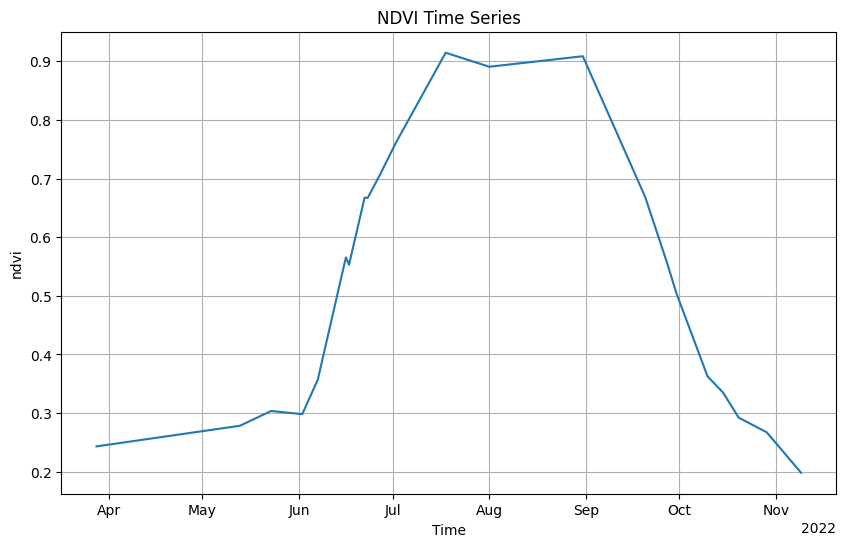

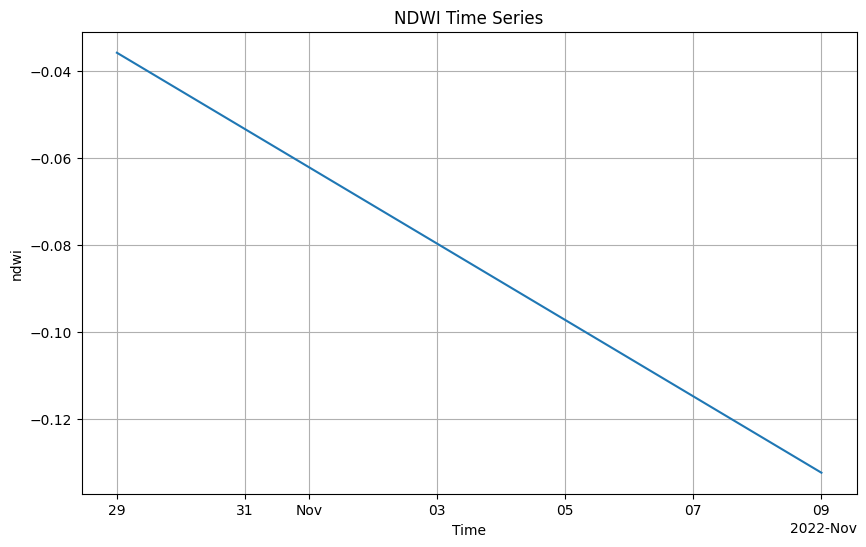

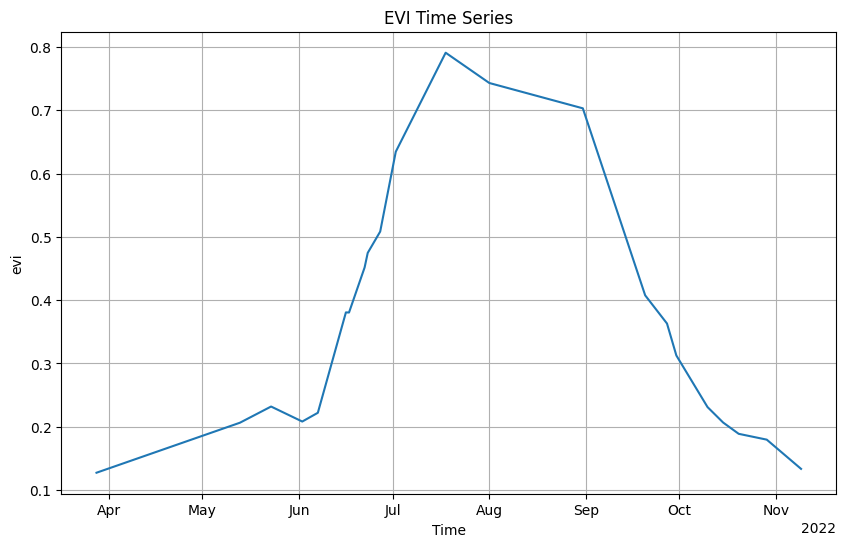

In [6]:
from matplotlib import pyplot as plt
import numpy as np

# get list of available bands from the analytics datacube
bands = list(datacube.data_vars.keys())

for band in bands:
    plt.figure(figsize=(10, 6))
    indicator_ds = datacube.sel(band=band.upper())[band].sortby('time')

    # Exclude NaN values to calculate the mean
    masked_data_array = indicator_ds.where(~np.isnan(indicator_ds))

    # index mean calculation
    mean_index = masked_data_array.mean(dim=['x', 'y'])

    # plot 
    mean_index.plot.line(x='time')

    # labels & title
    plt.xlabel('Time')
    plt.ylabel(band)
    plt.title(f'{band.upper()} Time Series')
    plt.grid()    
    plt.show()

### Cumulative index indicator values over the defined period.

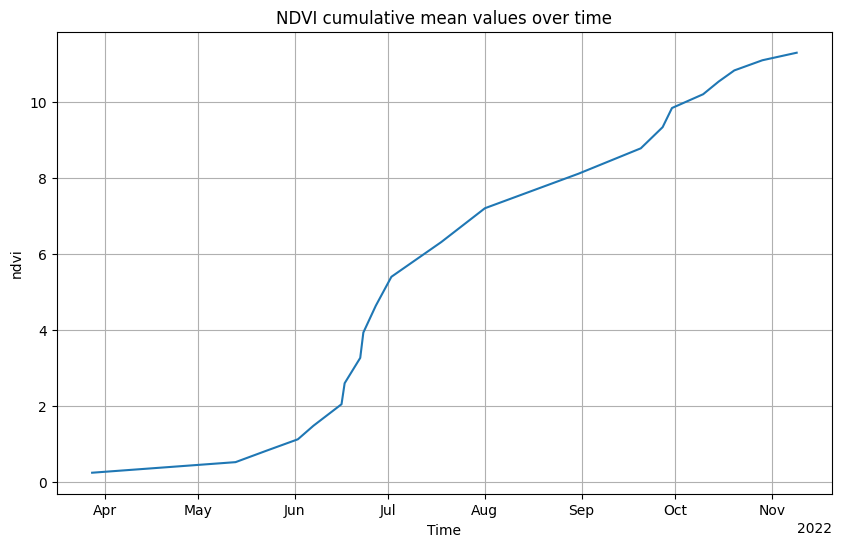

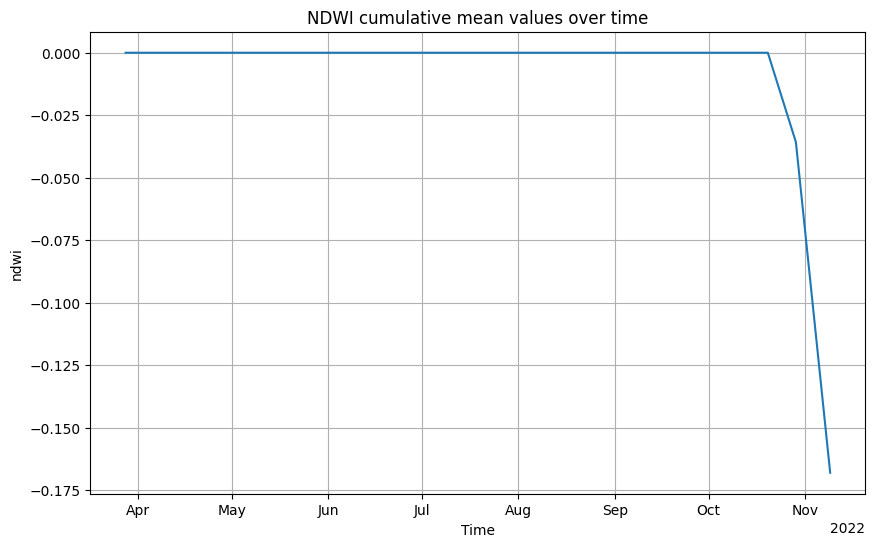

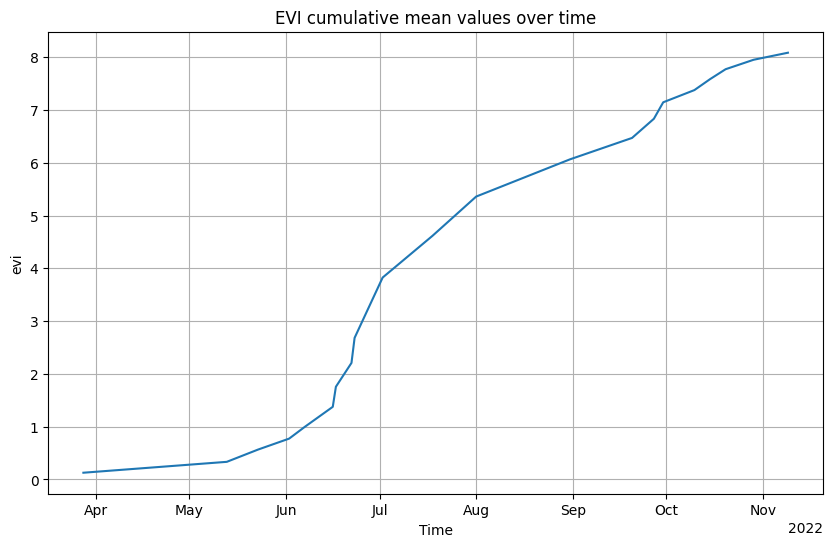

In [9]:
# get list of available bands from the analytics datacube
bands = list(datacube.data_vars.keys())

for band in bands:
    plt.figure(figsize=(10, 6))
    indicator_ds = datacube.sel(band=band.upper())[band].sortby('time')

    # Exclude NaN values to calculate the mean
    masked_data_array = indicator_ds.where(~np.isnan(indicator_ds))

    # index mean calculation
    mean_index = masked_data_array.mean(dim=['x', 'y'])

    # cumsum mean index calculation
    cumul_index_ds = mean_index.cumsum(dim='time')

    # plot 
    cumul_index_ds.plot.line(x='time')

    # labels & title
    plt.xlabel('Time')
    plt.ylabel(band)
    plt.title(f'{band.upper()} cumulative mean values over time')
    plt.grid()    
    plt.show()